# Setup

## Packages

In [1]:
%load_ext watermark

import numpy as np
import xarray as xr
import pandas as pd
import xcdat as xc
import intake

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import regionmask

import cmocean.cm as cmo

%watermark -iv

xcdat     : 0.6.0
cmocean   : 3.0.3
regionmask: 0.11.0
cartopy   : 0.22.0
pandas    : 2.2.0
numpy     : 1.24.4
intake    : 0.0.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
matplotlib: 3.8.0
xarray    : 2023.10.1



## Figure settings

In [2]:
%config InlineBackend.figure_formats = ['png']
mpl.rcParams['figure.dpi'] = 120

# Functions

In [3]:
def calculate_annual_timeseries(da):
    """
    Calculates the annual timeseries, weighted by the number of days in each month
    """
    nyears = len(da.groupby('time.year'))
    month_length = da.time.dt.days_in_month

    weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()        
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyears)) 

    return (da * weights).groupby('time.year').sum(dim='time')

# Load data

## Tree ring coordinates

In [4]:
tree_ring_coords = pd.read_csv('./latlon_gym_ang.csv', usecols=[0,1,2])

tree_ring_coords = tree_ring_coords.rename(columns={'gym=0/ang=1': 'isAng'})
tree_ring_coords = tree_ring_coords.replace({'isAng': np.nan}, 2)

ang_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==1].drop(columns='isAng')
gym_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==0].drop(columns='isAng')

In [5]:
tree_ring_coords

,lat,lon,isAng
0,-38.716000,-71.700000,0.0
1,-38.428000,-71.538000,0.0
2,-33.051000,120.795000,0.0
3,-22.851389,118.627778,0.0
4,-22.851000,117.628000,0.0
...,...,...,...
428,45.750759,6.191114,2.0
429,45.820000,-121.952000,0.0
430,47.210000,11.452000,0.0
431,48.472690,-79.330129,0.0


## Atmospheric CO2 concentration

Found in CESM input data directory on the NCAR filesystem, not totally sure of the validity for our use case.

`/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/CO2/fco2_datm_global_ssp370_simyr_1750-2025_CMIP6_c201113.nc`

In [35]:
co2ppm_1 = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/fco2/fco2_datm_global_simyr_1750-2014_CMIP6_c180929.nc', decode_times=False)
co2ppm_1['time'] = pd.date_range(start='1750', end='2014', freq='YS')
co2ppm_1 = co2ppm_1['CO2']

In [33]:
co2ppm = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/fco2/fco2_datm_global_ssp370_simyr_1750-2025_CMIP6_c201113.nc', decode_times=True)
co2ppm['time'] = pd.date_range(start='1750', end='2025', freq='YS')
co2ppm = co2ppm['CO2'].sel(time=slice('1750', '2014'))
co2ppm = co2ppm[:,0,0]

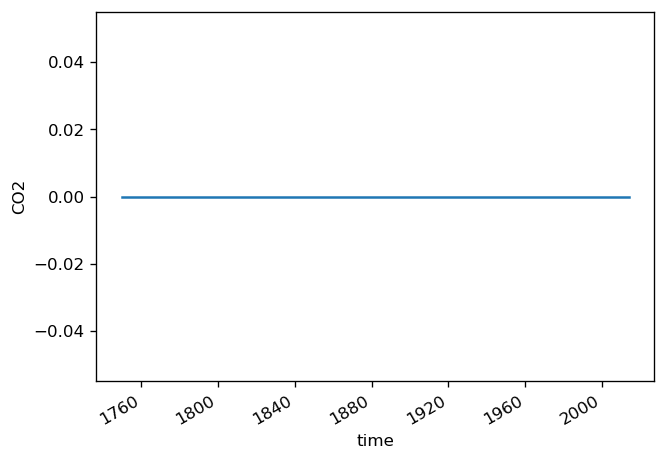

In [37]:
(co2ppm - co2ppm_1).plot(figsize=(6,4))

## Processed CESM2 historical simulation

In [13]:
# Create slice objects to select the corresponding ang/gym tree PFTs
angtreepft_index_slice = slice(4,8)
gymtreepft_index_slice = slice(1,3)

tree_type_index_slice = {
    'ang': angtreepft_index_slice,
    'gym': gymtreepft_index_slice,
}

In [14]:
# Load arrays of site indices corresponding to ang/gym tree ring classification
sites_with_gymtreepfts = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/sites_with_gymtreepfts.nc')['sites_with_gymtreepfts']
sites_with_angtreepfts = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/sites_with_angtreepfts.nc')['sites_with_angtreepfts']

In [15]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

variables = [
    'GPP', 'GSSUNLN', 'FCTR', 'TLAI',
    # 'WUE'
]

conv_factors = [60 * 60 * 24 * 365, 1 / 1000, 1000 * 1000 / 2.26e6, 1, 1]

natpft_pct_threshold = 0

site_data = {}
grid_data = {}
for i, (var, conv) in enumerate(zip(variables, conv_factors)):
    site_data[var] = {}
    grid_data[var] = {}

    this_site_data = xr.open_dataset(f'{main_directory}/sites_from_gridded/{case_name}.clm2.h1.{var}.185001-201412_sites.nc')
    this_site_data = this_site_data.sel(time=slice('1851-01', '2014-12'))

    for tree_type, tree_type_index in zip(['ang', 'gym'], [angtreepft_index_slice, gymtreepft_index_slice]):
        site_data[var][tree_type] = this_site_data.sel(pft=tree_type_index).mean(dim='pft')
        site_data[var][tree_type] = calculate_annual_timeseries(site_data[var][tree_type])
        site_data[var][tree_type] = site_data[var][tree_type][var] * conv

        grid_data[var][tree_type] = xr.open_dataset(f'{main_directory}/timeseries_from_gridded/{case_name}.clm2.h1.{var}.185001-201412_gridded_{tree_type}_annts.nc')
        grid_data[var][tree_type] = grid_data[var][tree_type].sel(year=slice('1851', '2014'))
        grid_data[var][tree_type] = grid_data[var][tree_type][var] * conv

        if i == 0:
            surfdata = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1850_c190214.nc')
            surfdata = surfdata.rename({'lsmlat': 'lat', 'lsmlon': 'lon'})
            surfdata = surfdata.assign_coords({'lat': grid_data[var][tree_type].lat, 'lon': grid_data[var][tree_type].lon})

        grid_tree_type_pct = surfdata['PCT_NAT_PFT'].sel(natpft=tree_type_index).sum(dim='natpft')
        grid_data[var][tree_type] = grid_data[var][tree_type].where(grid_tree_type_pct>natpft_pct_threshold)

## Climate space variables (P and T)

In [132]:
main_directory = '/glade/campaign/cgd/tss/common/Land_Only_Simulations/CTSM51_DEV/CLM50_CTSM51_LAND_ONLY_RELEASE'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

pr = xr.open_dataset(f'{main_directory}/{case_name}/lnd/proc/tseries/month_1/{case_name}.clm2.h0.RAIN_FROM_ATM.185001-201412.nc')['RAIN_FROM_ATM']
ts = xr.open_dataset(f'{main_directory}/{case_name}/lnd/proc/tseries/month_1/{case_name}.clm2.h0.TSA.185001-201412.nc')['TSA']

pr = calculate_annual_timeseries(pr)
ts = calculate_annual_timeseries(ts)

pr = pr.sel(year=slice('1901', '2014'))
ts = ts.sel(year=slice('1901', '2014'))

pr = pr.mean(dim='year')
ts = ts.mean(dim='year')

pr = pr * 60 * 60 * 24 * 365
ts = ts - 273.15

pr = pr.where(surfdata['PCT_NAT_PFT'].sel(natpft=slice(1,8)).sum(dim='natpft')>0)
ts = ts.where(surfdata['PCT_NAT_PFT'].sel(natpft=slice(1,8)).sum(dim='natpft')>0).where(ts>-100).where(ts<100)

pr_ang = pr.where(surfdata['PCT_NAT_PFT'].sel(natpft=angtreepft_index_slice).sum(dim='natpft')>0)
ts_ang = ts.where(surfdata['PCT_NAT_PFT'].sel(natpft=angtreepft_index_slice).sum(dim='natpft')>0)

pr_gym = pr.where(surfdata['PCT_NAT_PFT'].sel(natpft=gymtreepft_index_slice).sum(dim='natpft')>0)
ts_gym = ts.where(surfdata['PCT_NAT_PFT'].sel(natpft=gymtreepft_index_slice).sum(dim='natpft')>0)

pr_flat = pr.values.ravel()[~np.isnan(ts.values.ravel())]
ts_flat = ts.values.ravel()[~np.isnan(ts.values.ravel())]

pr_ang_flat = pr_ang.values.ravel()[~np.isnan(ts.values.ravel())]
ts_ang_flat = ts_ang.values.ravel()[~np.isnan(ts.values.ravel())]

pr_gym_flat = pr_gym.values.ravel()[~np.isnan(ts.values.ravel())]
ts_gym_flat = ts_gym.values.ravel()[~np.isnan(ts.values.ravel())]

In [133]:
def select_sites_from_gridded_data(xr_grid_data, df_site_data):
    """
    Add docstring
    """
    nsite = df_site_data.iloc[:,0].size
    np_site_data = np.empty((nsite), dtype=xr.DataArray)

    # Select the grid box nearest to the coordinates for each site
    for i, row in df_site_data.iterrows():
        gridbox_timeseries = xr_grid_data.sel(lat=row['lat'], lon=row['lon'], method='nearest')
        np_site_data[i] = gridbox_timeseries

    xr_site_data = xr.concat(np_site_data, dim='site')
    xr_site_data = xr_site_data.assign_coords({'site': np.arange(nsite)})

    return xr_site_data

In [134]:
tree_ring_coords = pd.read_csv('/glade/u/home/bbuchovecky/projects/wue_partition/latlon_gym_ang.csv', usecols=[0,1])

pr_site = select_sites_from_gridded_data(pr, tree_ring_coords)
ts_site = select_sites_from_gridded_data(ts, tree_ring_coords)

Text(0.5, 0, 'Near-surface air temperature [$^{\\circ}$C]')

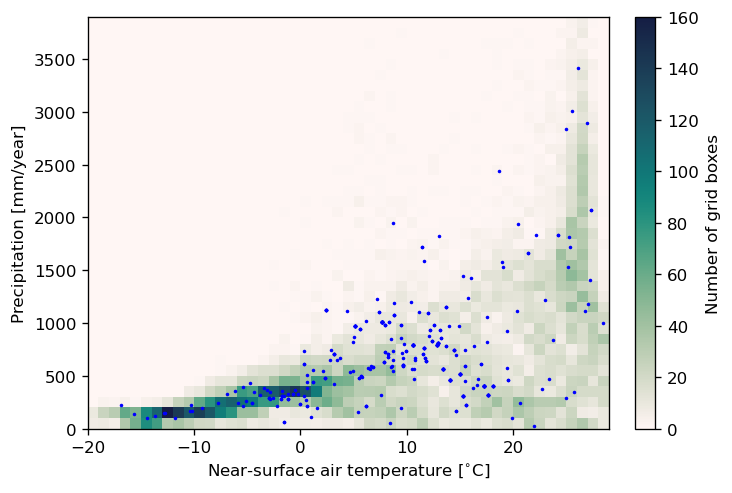

In [150]:
fig, ax = plt.subplots(
    figsize=(6,4),
    layout='constrained',
)

hst = ax.hist2d(
    ts_flat, pr_flat,
    bins=[
        np.arange(-20, 30, 1),
        np.arange(0, 4000, 100),
    ],
    cmap=cmo.tempo,
    vmin=0, vmax=160,
)

for i in range(433):
    ax.scatter(
        ts_site.isel(site=i),
        pr_site.isel(site=i),
        s=5,
        marker='.',
        facecolor='blue'
    )

cb = fig.colorbar(hst[3], ax=ax)
cb.set_label('Number of grid boxes')

ax.set_ylabel('Precipitation [mm/year]')
ax.set_xlabel('Near-surface air temperature [$^{\circ}$C]')

Text(0.5, 0, 'Near-surface air temperature [$^{\\circ}$C]')

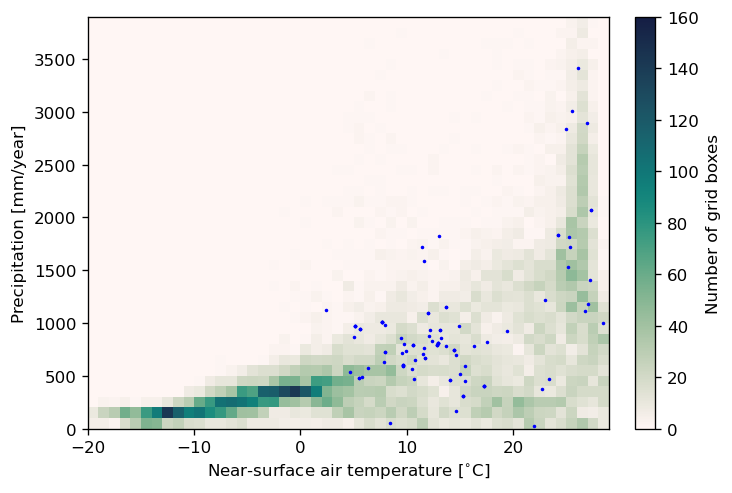

In [148]:
fig, ax = plt.subplots(
    figsize=(6,4),
    layout='constrained',
)

hst = ax.hist2d(
    ts_ang_flat, pr_ang_flat,
    bins=[
        np.arange(-20, 30, 1),
        np.arange(0, 4000, 100),
    ],
    cmap=cmo.tempo,
    vmin=0, vmax=160,
)

for i in sites_with_angtreepfts:
    ax.scatter(
        ts_site.isel(site=i),
        pr_site.isel(site=i),
        s=5,
        marker='.',
        facecolor='blue'
    )

cb = fig.colorbar(hst[3], ax=ax)
cb.set_label('Number of grid boxes')

ax.set_ylabel('Precipitation [mm/year]')
ax.set_xlabel('Near-surface air temperature [$^{\circ}$C]')

Text(0.5, 0, 'Near-surface air temperature [$^{\\circ}$C]')

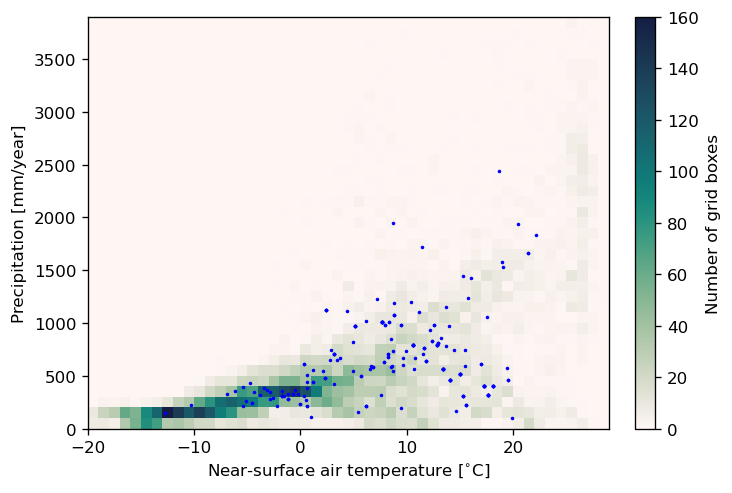

In [149]:
fig, ax = plt.subplots(
    figsize=(6,4),
    layout='constrained',
)

hst = ax.hist2d(
    ts_gym_flat, pr_gym_flat,
    bins=[
        np.arange(-20, 30, 1),
        np.arange(0, 4000, 100),
    ],
    cmap=cmo.tempo,
    vmin=0, vmax=160,
)

for i in sites_with_gymtreepfts:
    ax.scatter(
        ts_site.isel(site=i),
        pr_site.isel(site=i),
        s=5,
        marker='.',
        facecolor='blue'
    )

cb = fig.colorbar(hst[3], ax=ax)
cb.set_label('Number of grid boxes')

ax.set_ylabel('Precipitation [mm/year]')
ax.set_xlabel('Near-surface air temperature [$^{\circ}$C]')

# Compute trends

In [21]:
variables = [
    'GPP', 'GSSUNLN', 'FCTR',
    # 'TLAI', 'WUE'
]

time_periods = {
    'full': slice('1901', '2014'),
    'early': slice('1901', '1964'),
    'late': slice('1965', '2014')
}

site_fits = {}
grid_fits = {}

site_trends = {}
grid_trends = {}
for var, conv in zip(variables, conv_factors):
    site_fits[var] = {}
    grid_fits[var] = {}

    site_trends[var] = {}
    grid_trends[var] = {}

    for tree_type in ['ang', 'gym']:
        site_fits[var][tree_type] = {}
        grid_fits[var][tree_type] = {}

        site_trends[var][tree_type] = {}
        grid_trends[var][tree_type] = {}

        for time_descr, time_slice in time_periods.items():
            this_site_data = site_data[var][tree_type].sel(year=time_slice)
            this_site_data['year'] = np.arange(this_site_data['year'].size)

            site_fits[var][tree_type][time_descr] = this_site_data.polyfit(dim='year', deg=1, full=True)
            site_trends[var][tree_type][time_descr] = site_fits[var][tree_type][time_descr]['polyfit_coefficients'].sel(degree=1) * 10  # convert per year to per decade


            this_grid_data = grid_data[var][tree_type].sel(year=time_slice)
            this_grid_data['year'] = np.arange(this_grid_data['year'].size)

            grid_fits[var][tree_type][time_descr] = this_grid_data.polyfit(dim='year', deg=1, full=True, skipna=True)
            grid_trends[var][tree_type][time_descr] = grid_fits[var][tree_type][time_descr]['polyfit_coefficients'].sel(degree=1) * 10  # convert per year to per decade

# [CO2] plot

Text(0, 0.5, 'Transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$]')

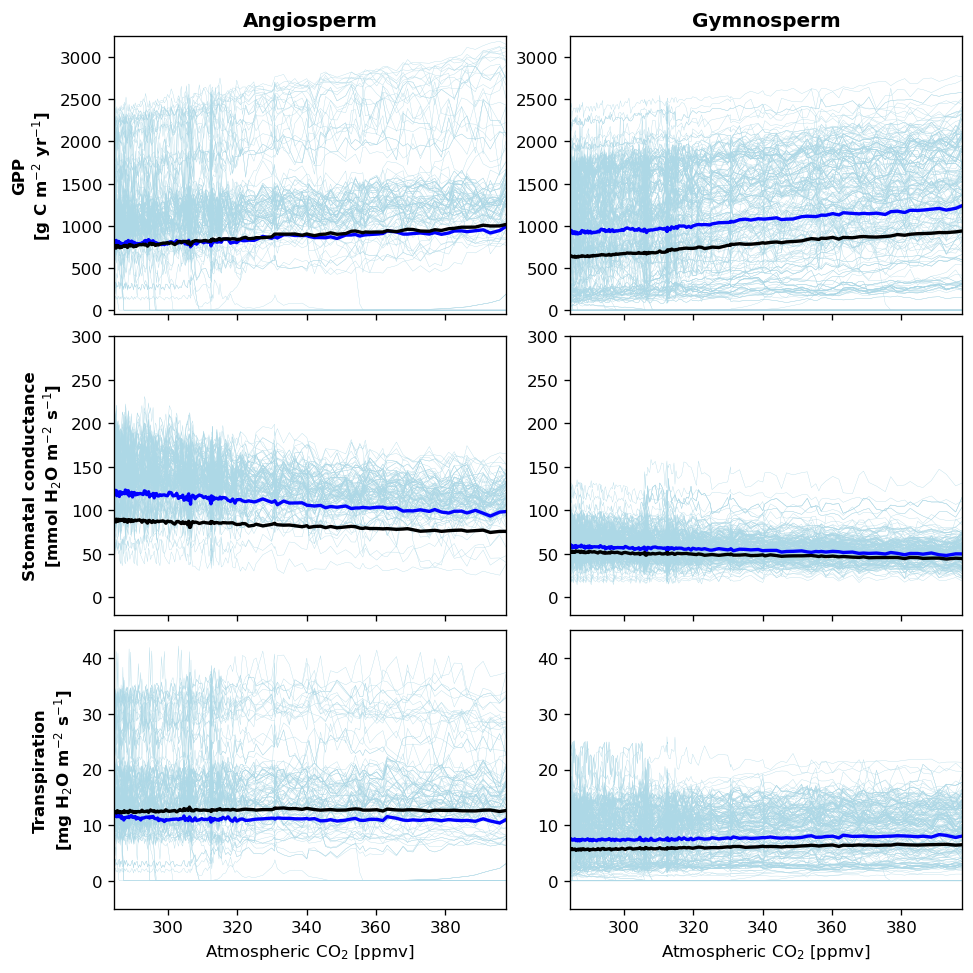

In [16]:
fig, axes = plt.subplots(
    3, 2, figsize=(8, 8),
    layout='constrained',
    sharex=True,
)
ax = axes.ravel()

site_linecolor = 'lightblue'
site_mean_linecolor = 'blue'
grid_linecolor = 'black'

## Angiosperm - sites

for i in sites_with_angtreepfts:
    axes[0, 0].plot(
        co2ppm,
        site_data['GPP']['ang'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)

    axes[1, 0].plot(
        co2ppm,
        site_data['GSSUNLN']['ang'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)
    
    axes[2, 0].plot(
        co2ppm,
        site_data['FCTR']['ang'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)

axes[0, 0].plot(
    co2ppm,
    site_data['GPP']['ang'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)

axes[1, 0].plot(
    co2ppm,
    site_data['GSSUNLN']['ang'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)

axes[2, 0].plot(
    co2ppm,
    site_data['FCTR']['ang'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)

## Gymnosperm - sites

for i in sites_with_gymtreepfts:
    axes[0, 1].plot(
        co2ppm,
        site_data['GPP']['gym'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)

    axes[1, 1].plot(
        co2ppm,
        site_data['GSSUNLN']['gym'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)
    
    axes[2, 1].plot(
        co2ppm,
        site_data['FCTR']['gym'].isel(site=i.values),
        '-', c=site_linecolor, lw=0.2)
    
axes[0, 1].plot(
    co2ppm,
    site_data['GPP']['gym'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)

axes[1, 1].plot(
    co2ppm,
    site_data['GSSUNLN']['gym'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)

axes[2, 1].plot(
    co2ppm,
    site_data['FCTR']['gym'].mean(dim='site'),
    '-', c=site_mean_linecolor, lw=2)



## Angiosperm - global

axes[0, 0].plot(
    co2ppm,
    grid_data['GPP']['ang'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

axes[1, 0].plot(
    co2ppm,
    grid_data['GSSUNLN']['ang'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

axes[2, 0].plot(
    co2ppm,
    grid_data['FCTR']['ang'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

## Gymnosperm - global

axes[0, 1].plot(
    co2ppm,
    grid_data['GPP']['gym'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

axes[1, 1].plot(
    co2ppm,
    grid_data['GSSUNLN']['gym'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

axes[2, 1].plot(
    co2ppm,
    grid_data['FCTR']['gym'].mean(dim=['lat', 'lon'], skipna=True),
    '-', c=grid_linecolor, lw=2)

## Figure settings

for a in ax:
    a.set_xlim(co2ppm[0], co2ppm[-1])

for a in ax[0:2]:
    a.set_ylim(-50, 3250)

for a in ax[2:4]:
    a.set_ylim(-20, 300)

for a in ax[4:6]:
    a.set_ylim(-5, 45)

for a in ax[4:]:
    a.set_xlabel('Atmospheric CO$_2$ [ppmv]')

axes[0, 0].set_title('Angiosperm', fontweight='bold')
axes[0, 1].set_title('Gymnosperm', fontweight='bold')

ax[0].set_ylabel('GPP\n[g C m$^{-2}$ yr$^{-1}$]', fontweight='bold')
ax[2].set_ylabel('Stomatal conductance\n[mmol H$_2$O m$^{-2}$ s$^{-1}$]', fontweight='bold')
ax[4].set_ylabel('Transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$]', fontweight='bold')

# Histograms

In [154]:
import scipy.stats as stats

ang full  0.4683
ang early  0.0071
ang late  0.1709
gym full  0.0153
gym early  0.0610
gym late  0.0055


Text(-0.25, 0.5, 'Gymnosperm')

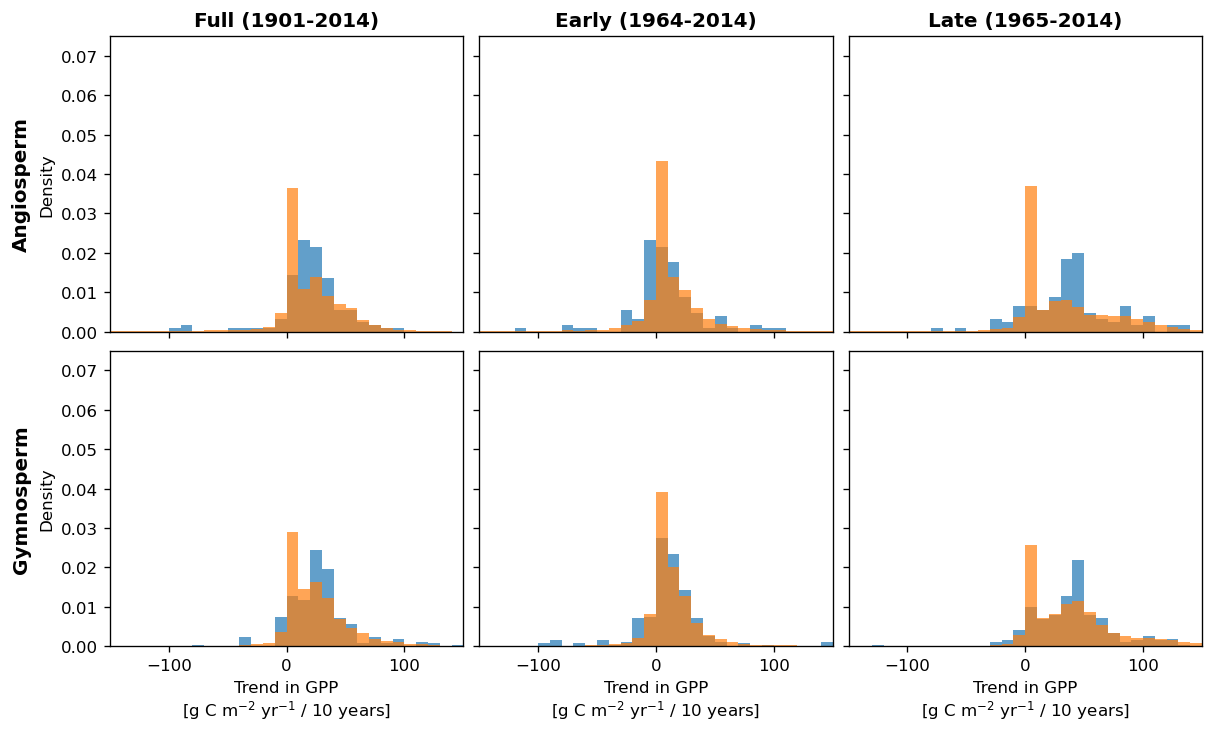

In [156]:
fig, axes = plt.subplots(
    2, 3, figsize=(10,6),
    layout='constrained',
    sharex=True, sharey=True
)
ax = axes.ravel()

var = 'GPP'

for i, (tree_type, tree_type_sites) in enumerate(zip(['ang', 'gym'], [sites_with_angtreepfts, sites_with_gymtreepfts])):
    for j, time_descr in enumerate(['full', 'early', 'late']):
        axes[i, j].hist(
            x=site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(),
            bins=np.arange(-400, 400+0.1, 10),
            density=True,
            alpha=0.7,
        )

        axes[i, j].hist(
            x=grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())],
            bins=np.arange(-400, 400+0.1, 10),
            density=True,
            alpha=0.7,
        )

        print(f'{tree_type} {time_descr} {stats.ttest_ind(site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(), grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())]).pvalue : 0.4f}')
        

for a in ax:
    a.set_xlim(-150, 150)
    a.set_ylim(0, 0.075)
    a.set_xticks([-100, 0, 100])

for a in ax[3:]:
    a.set_xlabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]')

ax[0].set_ylabel('Density')
ax[3].set_ylabel('Density')

ax[0].set_title('Full (1901-2014)', fontweight='bold')
ax[1].set_title('Early (1964-2014)', fontweight='bold')
ax[2].set_title('Late (1965-2014)', fontweight='bold')

ax[0].text(
    -0.25, 0.5, 'Angiosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[0].transAxes
)

ax[3].text(
    -0.25, 0.5, 'Gymnosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[3].transAxes
)

ang full  0.0000
ang early  0.0000
ang late  0.0000
gym full  0.0007
gym early  0.1847
gym late  0.0000


Text(-0.25, 0.5, 'Gymnosperm')

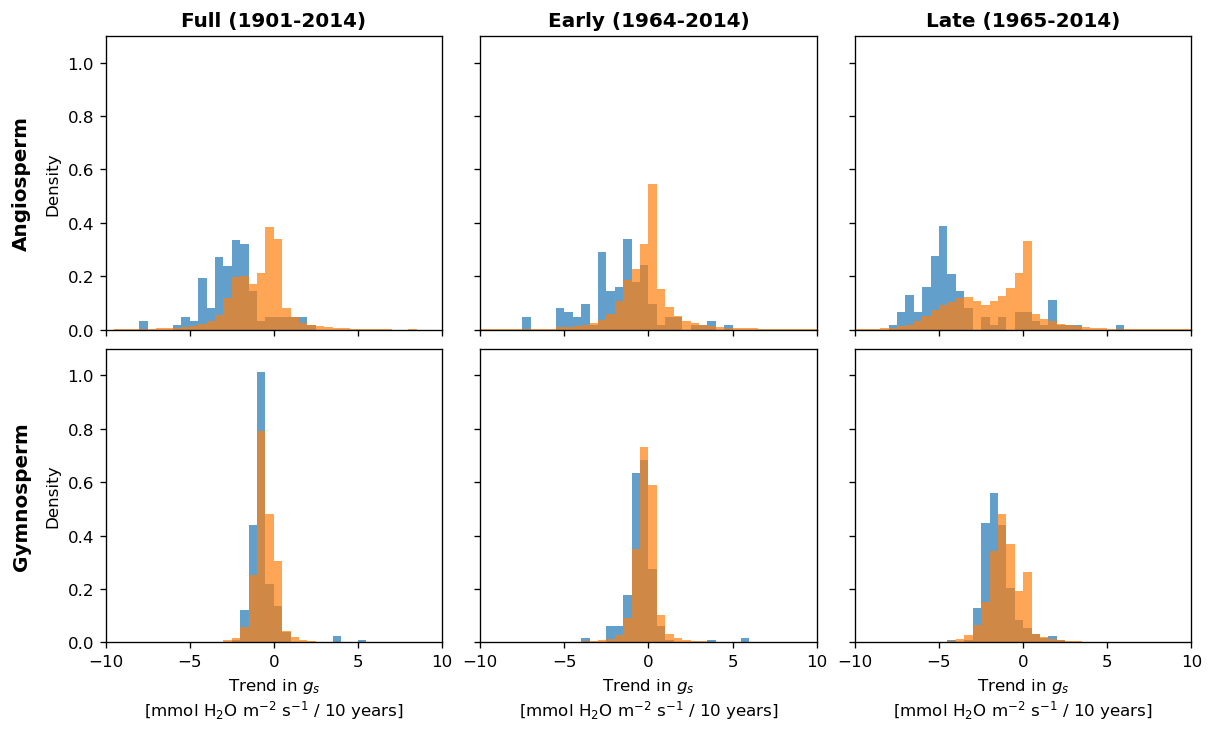

In [157]:
fig, axes = plt.subplots(
    2, 3, figsize=(10,6),
    layout='constrained',
    sharex=True, sharey=True
)
ax = axes.ravel()

var = 'GSSUNLN'

for i, (tree_type, tree_type_sites) in enumerate(zip(['ang', 'gym'], [sites_with_angtreepfts, sites_with_gymtreepfts])):
    for j, time_descr in enumerate(['full', 'early', 'late']):
        axes[i, j].hist(
            x=site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(),
            bins=np.arange(-10, 10+0.1, 0.5),
            density=True,
            alpha=0.7,
        )

        axes[i, j].hist(
            x=grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())],
            bins=np.arange(-10, 10+0.1, 0.5),
            density=True,
            alpha=0.7,
        )

        print(f'{tree_type} {time_descr} {stats.ttest_ind(site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(), grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())]).pvalue : 0.4f}')

for a in ax:
    a.set_xlim(-10, 10)
    a.set_ylim(0, 1.1)

for a in ax[3:]:
    a.set_xlabel('Trend in $g_s$\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]')

ax[0].set_ylabel('Density')
ax[3].set_ylabel('Density')

ax[0].set_title('Full (1901-2014)', fontweight='bold')
ax[1].set_title('Early (1964-2014)', fontweight='bold')
ax[2].set_title('Late (1965-2014)', fontweight='bold')

ax[0].text(
    -0.25, 0.5, 'Angiosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[0].transAxes
)

ax[3].text(
    -0.25, 0.5, 'Gymnosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[3].transAxes
)

In [ ]:
fig, axes = plt.subplots(
    2, 3, figsize=(10,6),
    layout='constrained',
    sharex=True, sharey=True
)
ax = axes.ravel()

var = 'FCTR'

for i, (tree_type, tree_type_sites) in enumerate(zip(['ang', 'gym'], [sites_with_angtreepfts, sites_with_gymtreepfts])):
    for j, time_descr in enumerate(['full', 'early', 'late']):
        axes[i, j].hist(
            x=site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(),
            bins=np.arange(-1.5, 1.5+0.001, 0.1),
            density=True,
            alpha=0.7,
        )

        axes[i, j].hist(
            x=grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())],
            bins=np.arange(-1.5, 1.5+0.001, 0.1),
            density=True,
            alpha=0.7,
        )

        print(f'{tree_type} {time_descr} {stats.ttest_ind(site_trends[var][tree_type][time_descr].sel(site=tree_type_sites).values.ravel(), grid_trends[var][tree_type][time_descr].values.ravel()[~np.isnan(grid_trends[var][tree_type][time_descr].values.ravel())]).pvalue : 0.4f}')

for a in ax[3:]:
    a.set_xlabel('Trend in transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]')

ax[0].set_ylabel('Density')
ax[3].set_ylabel('Density')

ax[0].set_title('Full (1901-2014)', fontweight='bold')
ax[1].set_title('Early (1964-2014)', fontweight='bold')
ax[2].set_title('Late (1965-2014)', fontweight='bold')

ax[0].text(
    -0.25, 0.5, 'Angiosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[0].transAxes
)

ax[3].text(
    -0.25, 0.5, 'Gymnosperm',
    fontsize=12, fontweight='bold',
    ha='center', va='center', rotation=90,
    transform=ax[3].transAxes
)

ang full  0.1498
ang early  0.1205
ang late  0.5612
gym full  0.1239
gym early  0.8174
gym late  0.0497


Text(-0.25, 0.5, 'Gymnosperm')